In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e1/sample_submission.csv
/kaggle/input/playground-series-s5e1/train.csv
/kaggle/input/playground-series-s5e1/test.csv
/kaggle/input/cbfitmodels/cbfit_Singapore
/kaggle/input/cbfitmodels/cbfit_Italy
/kaggle/input/cbfitmodels/cbfit_Finland
/kaggle/input/cbfitmodels/cbfit_Canada
/kaggle/input/cbfitmodels/cbfit_Norway
/kaggle/input/cbfitmodels/cbfit_Kenya
/kaggle/input/cbfitmodels/__results___files/__results___9_0.png
/kaggle/input/cbfitmodels/__results___files/__results___64_1.png
/kaggle/input/cbfitmodels/__results___files/__results___13_0.png
/kaggle/input/cbfitmodels/catboost_info/test_error.tsv
/kaggle/input/cbfitmodels/catboost_info/learn_error.tsv
/kaggle/input/cbfitmodels/catboost_info/catboost_training.json
/kaggle/input/cbfitmodels/catboost_info/time_left.tsv
/kaggle/input/cbfitmodels/catboost_info/learn/events.out.tfevents
/kaggle/input/cbfitmodels/catboost_info/test/events.out.tfevents


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import SplineTransformer


def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

# Sample quarterly data
# data = {'quarter': [1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4],
#         'value': [10, 15, 12, 18, 11, 16, 13, 19, 12, 17, 14, 20]}
# df = pd.DataFrame(data)

# # Create periodic spline transformer
# qt = periodic_spline_transformer(12, 4)

# # Transform the 'quarter' feature
# quarter = qt.fit_transform(df_train[['Month']])[:,0]

# # Add transformed features to DataFrame
# print(quarter)

In [3]:
check_pg=[]

In [4]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    check_pg.append(freqencies)
    check_pg.append(spectrum)
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    plt.savefig('pg.png')
    return ax

In [5]:
!pip install optuna-integration[catboost]
!pip install -U holidays

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.7 MB/s eta 0:00:0000:01
  Attempting uninstall: holidays
    Found existing installation: holidays 0.57
    Uninstalling holidays-0.57:
      Successfully uninstalled holidays-0.57


In [6]:
!pip install -U pycountry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 59.0 MB/s eta 0:00:00:00:010:01


In [7]:
import statsmodels

In [8]:
import pandas as pd
import numpy as np
import optuna
import catboost as cb
import matplotlib
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from optuna.integration import CatBoostPruningCallback
import pycountry 
import holidays
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import DeterministicProcess




In [9]:
df_train=pd.read_csv('/kaggle/input/playground-series-s5e1/train.csv')
df_test=pd.read_csv('/kaggle/input/playground-series-s5e1/test.csv')



In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB


In [11]:
df_train['store'].unique()

array(['Discount Stickers', 'Stickers for Less', 'Premium Sticker Mart'],
      dtype=object)

In [12]:
df_train[df_train['country']=='Kenya']['store'].unique()

array(['Discount Stickers', 'Stickers for Less', 'Premium Sticker Mart'],
      dtype=object)

In [14]:
df_train['product'].unique()

array(['Holographic Goose', 'Kaggle', 'Kaggle Tiers', 'Kerneler',
       'Kerneler Dark Mode'], dtype=object)

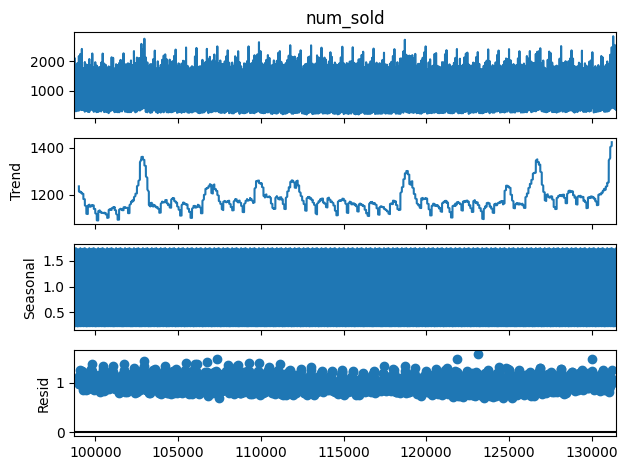

In [13]:
### import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Generate synthetic time series data
np.random.seed(42)
#df_train['date']=pd.to_datetime(df_train['date'])
#df_train=df_train.set_index('date')
df=df_train['num_sold']

#time = pd.date_range(start=df_train['date'].min, end=df_train['date'].max, periods=365, freq='D')
#series = 10 + 0.05 * np.arange(100) + np.sin(2 * np.pi * time.dayofyear / 365) + np.random.normal(0, 1, 100)
#df = pd.DataFrame({'date': time, 'value': series}).set_index('date')

# Decompose time series
decomposition = seasonal_decompose(
    df_train[(df_train['country']=='Singapore') & 
    (df_train['date'].str.contains('2013')) &
    (df_train['store']=='Premium Sticker Mart')]['num_sold'],
    model='multiplicative', period=30)  # Set period according to data frequency

# Plot components
decomposition.plot()
plt.show()


In [ ]:
# temp=pd.concat([df_train['date'],df_train['num_sold']],axis=1)
# sumsale2016=temp.groupby('date').mean().squeeze().loc['2013']
# #sumsale2016
# plot_periodogram(sumsale2016)

In [15]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
adf_result = adfuller(df_train[(df_train['country']=='Singapore') & (df_train['store']=='Discount Stickers')]['num_sold'])

# Print results
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
if adf_result[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is not stationary.")


ADF Statistic: -6.129147123657372
p-value: 8.484833374009022e-08
The series is stationary.


In [16]:
from statsmodels.tsa.stattools import kpss

# Perform KPSS test
kpss_result = kpss(df_train[(df_train['country']=='Singapore') & (df_train['store']=='Discount Stickers')]['num_sold'], regression='c')

# Print results
print("KPSS Statistic:", kpss_result[0])
print("p-value:", kpss_result[1])
if kpss_result[1] < 0.05:
    print("The series is not stationary (has a trend).")
else:
    print("The series is stationary.")

KPSS Statistic: 0.7976600279714846
p-value: 0.01
The series is not stationary (has a trend).


<ipython-input-16-b1e5399dac4b>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(df_train[(df_train['country']=='Singapore') & (df_train['store']=='Discount Stickers')]['num_sold'], regression='c')


In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB


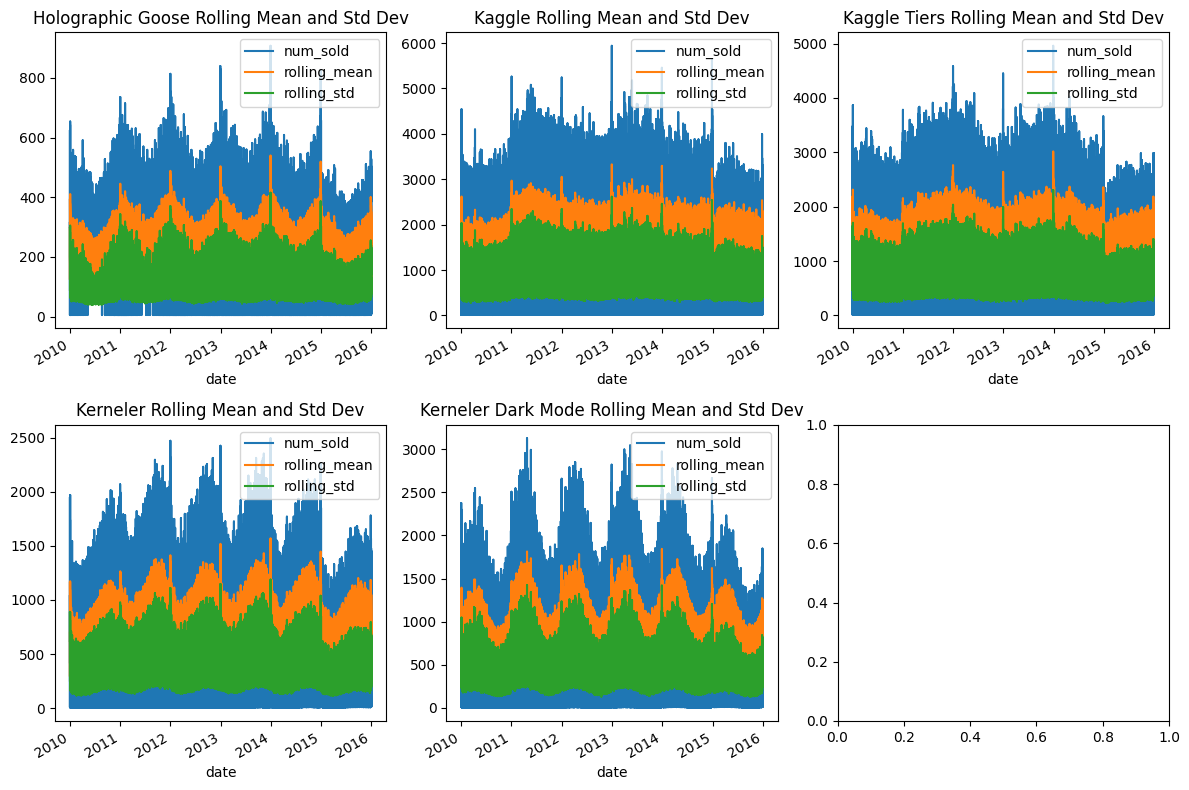

In [18]:
# Plot showing timeseries attributes: trend, seasonality 

# Create subplots: 2 rows, 3 columns
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()
productlist=df_train['product'].unique().tolist()
# Loop through each subplot and plot
for i, ax in enumerate(axes):
    if i<len(productlist):
        df=df_train[(df_train['product']==productlist[i])][['date','num_sold']]
        df.dropna(inplace=True)
        df['date']=pd.to_datetime(df['date'])
        df.set_index('date',inplace=True)
        df=df.loc['2010':'2015',:]
        df['rolling_mean'] = df['num_sold'].rolling(window=5).mean()
        df['rolling_std'] = df['num_sold'].rolling(window=5).std()
        df[['num_sold', 'rolling_mean', 'rolling_std']].plot(ax=ax,title=f'{productlist[i]} Rolling Mean and Std Dev')
    
plt.tight_layout()

# Show the plot
plt.show()
    

In [19]:
df_train.loc[df_train['country']=='Canada',['store','num_sold']].mode()

,store,num_sold
0,Discount Stickers,218.0
1,Premium Sticker Mart,NaN
2,Stickers for Less,NaN


In [20]:
df_train.iloc[df_train[df_train.isna().any(axis=1)].index,:].groupby(by=['country','store']).count()

id  date  product  num_sold
country store                                              
Canada  Discount Stickers     2558  2558     2558         0
        Premium Sticker Mart   380   380      380         0
        Stickers for Less     1308  1308     1308         0
Kenya   Discount Stickers     2621  2621     2621         0
        Premium Sticker Mart   646   646      646         0
        Stickers for Less     1358  1358     1358         0

In [21]:


def get_alpha2_code(country_name):
  """
  Gets the ISO 3166-1 Alpha-2 country code for the given country name.

  Args:
    country_name: The name of the country.

  Returns:
    The ISO 3166-1 Alpha-2 country code, or None if the country is not found.
  """
  try:
    country = pycountry.countries.search_fuzzy(country_name)[0]
    return country.alpha_2
  except LookupError:
    return None



In [22]:
# Function to create holiday sets for each country
def generate_country_holidays(countries, start_year, end_year):
    country_holidays = {}
    for country in countries:
        # Generate a holiday set for the range of years
        country_holidays[country] = holidays.CountryHoliday(country, years=range(start_year, end_year + 1)) 
    return country_holidays


In [23]:
df_train['Day']=pd.to_datetime(df_train['date']).dt.strftime("%d")
df_train['Month']=pd.to_datetime(df_train['date']).dt.strftime("%m")
df_train['Year']=pd.to_datetime(df_train['date']).dt.strftime("%Y")
df_train['Day_of_week']=pd.to_datetime(df_train['date']).dt.dayofweek
df_train['Week_No']=pd.to_datetime(df_train['date']).dt.isocalendar().week
df_train['is_weekend']=(df_train['Day_of_week']>=4).astype(int)
df_train['Quarter_Discrete'] = (df_train['Month'].astype(int) - 1) // 3 + 1
df_train['quarter_normalized'] = (df_train['Quarter_Discrete']-1)/3
df_train['month_normalized']=(df_train['Month'].astype(int)-1)/11
df_train['Month_Spline']=periodic_spline_transformer(12,4).fit_transform(df_train[['quarter_normalized']])[:,0]
df_train['Quarter_Spline']=periodic_spline_transformer(4,4).fit_transform(df_train[['quarter_normalized']])[:,0]
df_train['week_number_normalized'] = df_train['Week_No'] / df_train['Week_No'].max()
df_train['Week_Spline']=periodic_spline_transformer(53,5).fit_transform(df_train[['week_number_normalized']])[:,0]

In [24]:
df_train['log_num_sold']=np.log1p(df_train['num_sold'])

In [25]:
df_train.loc[:,['log_num_sold','num_sold']]

,log_num_sold,num_sold
0,NaN,NaN
1,6.881411,973.0
2,6.810142,906.0
3,6.049733,423.0
4,6.198479,491.0
...,...,...
230125,6.146329,466.0
230126,7.975221,2907.0
230127,7.740664,2299.0
230128,7.125283,1242.0


In [26]:
test=df_train[(df_train['country']=='Finland') & (df_train['store']=='Discount Stickers')].loc[:,['date','store','log_num_sold']].groupby(by=['date','store']).sum()

In [28]:
test.reset_index().set_index('date')

,store,log_num_sold
date,,
2010-01-01,Discount Stickers,30.665653
2010-01-02,Discount Stickers,30.384926
2010-01-03,Discount Stickers,31.108316
2010-01-04,Discount Stickers,29.624333
2010-01-05,Discount Stickers,29.440805
...,...,...
2016-12-27,Discount Stickers,29.758303
2016-12-28,Discount Stickers,30.140851
2016-12-29,Discount Stickers,30.560859


In [29]:
def consecutive_days_visited(df):
    """
    Calculates the number of consecutive days a store was visited.

    Args:
        df: pandas DataFrame with columns 'date', 'country', 'store'

    Returns:
        pandas DataFrame with an additional column 'consecutive_days' 
    """

    # Ensure date index is sorted
    df = df.sort_index()

    # Group by 'country' and 'store'
    grouped = df.groupby(['country', 'store'])

    # Calculate consecutive days within each group
    df['consecutive_days'] = (grouped.indices - grouped.indices.min()).dt.days + 1

    return df


In [30]:
allcountries=df_train['country'].unique()
countrycodes = list(map(lambda x:get_alpha2_code(x),allcountries)) 
unique_countries = [cc for cc in countrycodes if cc is not None]
print(countrycodes)

['CA', 'FI', 'IT', 'KE', 'NO', 'SG']


In [31]:
df_train['store']=df_train['store'].astype('category')
df_train['country']=df_train['country'].astype('category')
df_train['product']=df_train['product'].astype('category')
df_train['Day']=df_train['Day'].astype('category')
df_train['Month']=df_train['Month'].astype('category')
df_train['Year']=df_train['Year'].astype('category')
df_train['Day_of_week']=df_train['Day_of_week'].astype('category')


In [32]:
df_test['Day']=pd.to_datetime(df_test['date']).dt.strftime("%d")
df_test['Month']=pd.to_datetime(df_test['date']).dt.strftime("%m")
df_test['Year']=pd.to_datetime(df_test['date']).dt.strftime("%Y")
df_test['Day_of_week']=pd.to_datetime(df_test['date']).dt.dayofweek
df_test['Week_No']=pd.to_datetime(df_test['date']).dt.isocalendar().week
df_test['is_weekend']=(df_test['Day_of_week']>=4).astype(int)
df_test['Quarter_Discrete'] = (df_test['Month'].astype(int) - 1) // 3 + 1
df_test['quarter_normalized'] = (df_test['Quarter_Discrete']-1)/3
df_test['month_normalized']=(df_test['Month'].astype(int)-1)/11
df_test['Month_Spline']=periodic_spline_transformer(12,4).fit_transform(df_test[['quarter_normalized']])[:,0]
df_test['Quarter_Spline']=periodic_spline_transformer(4,4).fit_transform(df_test[['quarter_normalized']])[:,0]
df_test['week_number_normalized'] = df_test['Week_No'] / df_test['Week_No'].max()
df_test['Week_Spline']=periodic_spline_transformer(53,5).fit_transform(df_test[['week_number_normalized']])[:,0]


In [33]:
df_test.drop(['week_number_normalized','month_normalized','quarter_normalized'],axis=1,inplace=True)

In [34]:
df_train.drop(['week_number_normalized','month_normalized','quarter_normalized'],axis=1,inplace=True)

In [35]:
df_test['store']=df_test['store'].astype('category')
df_test['country']=df_test['country'].astype('category')
df_test['product']=df_test['product'].astype('category')
df_test['Day']=df_test['Day'].astype('category')
df_test['Month']=df_test['Month'].astype('category')
df_test['Year']=df_test['Year'].astype('category')
df_test['Day_of_week']=df_test['Day_of_week'].astype('category')


In [36]:
df_train['date']=pd.to_datetime(df_train['date'])
df_test['date']=pd.to_datetime(df_test['date'])

In [37]:
df_train['previous_visit']=df_train.reset_index().groupby(by=['country','store'])[['date']].diff()

<ipython-input-37-a9a4f327ce0c>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_train['previous_visit']=df_train.reset_index().groupby(by=['country','store'])[['date']].diff()


In [38]:
df_train['consec_days']=df_train.groupby(by=['country','store'])[['previous_visit']].cumsum()

<ipython-input-38-9b789beb13f0>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_train['consec_days']=df_train.groupby(by=['country','store'])[['previous_visit']].cumsum()


In [39]:
df_test['previous_visit']=df_test.reset_index().groupby(by=['country','store'])[['date']].diff()
df_test['consec_days']=df_test.groupby(by=['country','store'])[['previous_visit']].cumsum()

<ipython-input-39-b64440241ea2>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_test['previous_visit']=df_test.reset_index().groupby(by=['country','store'])[['date']].diff()
<ipython-input-39-b64440241ea2>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_test['consec_days']=df_test.groupby(by=['country','store'])[['previous_visit']].cumsum()


In [40]:
df_train.set_index('date',inplace=True)
Startmin=df_train.index.min()
df_train['days_since_start'] = (df_train.index - Startmin).days

# Add cycle hints based on time 
df_train['sin_year'] = np.sin(2 * np.pi * df_train['days_since_start'] / 365)
df_train['cos_year'] = np.cos(2 * np.pi * df_train['days_since_start'] / 365)
df_train['sin_month'] = np.sin(2 * np.pi * df_train['days_since_start'] / 30)
df_train['cos_month'] = np.cos(2 * np.pi * df_train['days_since_start'] / 30)

df_test.set_index('date',inplace=True)
df_test['days_since_start'] = (df_test.index - Startmin).days

# Add cycle hints based on time 
df_test['sin_year'] = np.sin(2 * np.pi * df_test['days_since_start'] / 365)
df_test['cos_year'] = np.cos(2 * np.pi * df_test['days_since_start'] / 365)
df_test['sin_month'] = np.sin(2 * np.pi * df_test['days_since_start'] / 30)
df_test['cos_month'] = np.cos(2 * np.pi * df_test['days_since_start'] / 30)

df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

In [ ]:
df_train.info()

In [41]:
#Get country

#Get holidays for each country
#allcountries.append("weirdcountry")
country_holidays={}

#df_train['date']=pd.to_datetime(df_train['date'])
start_year = df_train['date'].dt.year.min()
end_year = df_train['date'].dt.year.max()

country_holidays = generate_country_holidays(unique_countries, start_year, end_year)
holiday_df = pd.DataFrame([
    {'date': date, 'country_code': country, 'country': cname}
    for country in unique_countries
    for date in country_holidays[country]
    for cname in [pycountry.countries.get(alpha_2=cc).name for cc in unique_countries]]
)
holiday_df['is_holiday'] = 1
holiday_df['date']=pd.to_datetime(holiday_df['date'])
holiday_df.drop('country_code',axis=1,inplace=True)

df_train = df_train.merge(holiday_df, on=['date', 'country'], how='left').fillna({'is_holiday': 0})

In [ ]:
df_train[(df_train['country']=='Norway') & (df_train['store']=='Discount Stickers') & (df_train['previous_visit'].astype('int')>0)].consec_days.max

In [42]:
start_year = df_test['date'].dt.year.min()
end_year = df_test['date'].dt.year.max()
#unique_countries = [cc for cc in countrycodes if cc is not None]
country_holidays = generate_country_holidays(unique_countries, start_year, end_year)

holiday_df = pd.DataFrame([
    {'date': date, 'country_code': country, 'country': cname}
    for country in unique_countries
    for date in country_holidays[country]
    for cname in [pycountry.countries.get(alpha_2=cc).name for cc in unique_countries]]
)
holiday_df['is_holiday']=1
holiday_df['date']=pd.to_datetime(holiday_df['date'])
holiday_df.drop('country_code',axis=1,inplace=True)

df_test = df_test.merge(holiday_df, on=['date', 'country'], how='left').fillna({'is_holiday': 0})


In [43]:
df_test['is_holiday']=df_test['is_holiday'].astype(int)
df_test['is_holiday'].value_counts()

is_holiday
0    88290
1    18270
Name: count, dtype: int64

In [ ]:
df_train.set_index('date',inplace=True)
#df_test.set_index('date',inplace=True)

In [ ]:
#Graph for intrpolate is changing too much
#Not interpolate but just drop Na is better
#Interpolate missing num_sold

#df_train['date']=pd.to_datetime(df_train['date'])
#df = df_train.set_index('date')

# df_train = df_train.sort_values(by=['country', 'store', 'product', 'date'])

# # Impute NaN with interpolation (grouped by Country, Store, and Product)
# df_train['num_sold'] = df_train.groupby(['country', 'store', 'product'])['num_sold'].transform(
#     lambda group: group.interpolate(method='linear',limit=None,limit_direction='both').ffill().bfill()
# )
#df['num_sold'].isna().any()

In [ ]:
#condition = (df.num_sold.notna()) & (df['country']=='Canada') & (df['store']=='Discount Stickers') & (df['product']=='Holographic Goose')
#df[condition]


In [ ]:
##Get num_sold NaN product store and country
#t=df[df.num_sold.isna()].groupby(['country','store','product'])['product'].value_counts().to_dict()

In [ ]:
#Country store and product that have NaN
# for  k,v in t.items():
#     if v!=0:
#         print(k,v)

In [ ]:
#Find Holographic Goose num_sold in each country
nan_product = df_train[(df_train['product']=='Holographic Goose') & (df_train['num_sold'].notna())].groupby(['country'])['num_sold']
print("Mean")
print(nan_product.mean())
print("Median")
print(nan_product.median())
print("Mode")
print(nan_product.agg(pd.Series.mode))
print("Min")
print(nan_product.min())
print("Max")
print(nan_product.max())

Impute Canana NaN with 218.0 
Impute Kenya NaN with 5.0

In [44]:
df_train['previous_visit'].fillna(pd.to_timedelta(0),inplace=True)
df_train['consec_days'].fillna(pd.to_timedelta(0),inplace=True)
df_test['previous_visit'].fillna(pd.to_timedelta(0),inplace=True)
df_test['consec_days'].fillna(pd.to_timedelta(0),inplace=True)

df_train.dropna(inplace=True)
#df_test.dropna(inplace=True)

In [ ]:
#Impute Canada with 218
df_train.loc[df_train['country']=='Canada',['num_sold']]=df_train.loc[df_train['country']=='Canada',['num_sold']].fillna(218.0)

In [ ]:
#Impute Kenya with 5
df_train.loc[df_train['country']=='Kenya',['num_sold']]=df_train.loc[df_train['country']=='Kenya',['num_sold']].fillna(5.0)

In [ ]:
# nsmode = df_train['num_sold'].mode()
# df_train['num_sold']=df_train['num_sold'].fillna(nsmode[0])

In [47]:
#Get date back to feature after interpolation
df_train=df_train.reset_index(drop=True)

In [52]:
df_train['is_holiday']=df_train['is_holiday'].astype('int')
df_train['previous_visit']=pd.to_numeric(df_train['previous_visit'].dt.days,errors='coerce')
df_train['consec_days']=pd.to_numeric(df_train['consec_days'].dt.days,errors='coerce')
df_train['country']=df_train['country'].astype('category')

df_test['is_holiday']=df_test['is_holiday'].astype('int')
df_test['previous_visit']=pd.to_numeric(df_test['previous_visit'].dt.days,errors='coerce')
df_test['consec_days']=pd.to_numeric(df_test['consec_days'].dt.days,errors='coerce')
df_test['country']=df_test['country'].astype('category')

In [53]:
#log transform target
df_train['num_sold']=np.log1p(df_train['num_sold']) 


In [54]:
#Split data according to country into
from catboost import Pool
cv_country_train_pool={}
country_train_pool={}
country_valid_pool={}
countrylist=['Canada','Finland','Italy','Kenya','Norway','Singapore']

for c in countrylist:
    df=df_train[df_train['country']==c]
    train_x, valid_x, train_y, valid_y = train_test_split(df.drop(['id','num_sold','country'],axis=1),df['num_sold'],shuffle=False,test_size=0.20)
    cvtrain_x, cvvalid_x, cvtrain_y, cvvalid_y = train_test_split(df.drop(['id','num_sold','country'],axis=1),df['num_sold'],shuffle=False,test_size=0.10) 
    cats=df.select_dtypes('category').columns.to_list()
    cats.remove('country')
    cats.append('is_holiday')
    cats.append('Week_No')
    cats.append('is_weekend')
    cats.append('Quarter_Discrete')
    #train_weights = np.linspace(0.1, 1.0, len(train_x))
    #valid_weights = np.linspace(0.1, 1.0, len(valid_x)) # Linearly increasing weights
    # decay_rate=0.75
    # train_weights = decay_rate ** np.arange(len(train_x))[::-1]  # Exponentially increasing weights
    # valid_weights = decay_rate ** np.arange(len(valid_x))[::-1]  # Exponentially increasing weights
    cv_country_train_pool[c]=Pool(cvtrain_x,label=cvtrain_y,cat_features=cats)
    country_train_pool[c]=Pool(train_x,label=train_y,cat_features=cats)#,weight=train_weights)
    country_valid_pool[c]=Pool(valid_x,label=valid_y,cat_features=cats)#,weight=valid_weights)
    print(f"{c} train date {train_x['date'].min()} to {train_x['date'].max()}")
    print(f"{c} train loc  {train_x.index.min()} to {train_x.index.max()}")
    print(f"{c} valid date {valid_x['date'].min()} to {valid_x['date'].max()}") 
    print(f"{c} valid loc {valid_x.index.min()} to {valid_x.index.max()}")

Canada train date 2010-01-01 00:00:00 to 2015-07-18 00:00:00
Canada train loc  0 to 190498
Canada valid date 2015-07-18 00:00:00 to 2016-12-31 00:00:00
Canada valid loc 190499 to 240190
Finland train date 2010-01-01 00:00:00 to 2015-08-04 00:00:00
Finland train loc  84 to 191972
Finland valid date 2015-08-05 00:00:00 to 2016-12-31 00:00:00
Finland valid loc 192043 to 240205
Italy train date 2010-01-01 00:00:00 to 2015-08-04 00:00:00
Italy train loc  174 to 191987
Italy valid date 2015-08-05 00:00:00 to 2016-12-31 00:00:00
Italy valid loc 192058 to 240220
Kenya train date 2010-01-01 00:00:00 to 2015-09-02 00:00:00
Kenya train loc  264 to 194491
Kenya valid date 2015-09-02 00:00:00 to 2016-12-31 00:00:00
Kenya valid loc 194492 to 240234
Norway train date 2010-01-01 00:00:00 to 2015-08-04 00:00:00
Norway train loc  348 to 192015
Norway valid date 2015-08-05 00:00:00 to 2016-12-31 00:00:00
Norway valid loc 192086 to 240249
Singapore train date 2010-01-01 00:00:00 to 2015-08-04 00:00:00
Sin

In [59]:
df_train[(df_train['product']=='Kaggle')].drop_duplicates()

,date,id,country,store,product,num_sold,Day,Month,Year,Day_of_week,...,Week_Spline,log_num_sold,previous_visit,consec_days,days_since_start,sin_year,cos_year,sin_month,cos_month,is_holiday
0,2010-01-01,1,Canada,Discount Stickers,Kaggle,6.881411,01,01,2010,4,...,0.123807,6.881411,0,0,0,0.000000,1.000000,0.000000,1.000000,1
30,2010-01-01,6,Canada,Stickers for Less,Kaggle,7.516433,01,01,2010,4,...,0.123807,7.516433,0,0,0,0.000000,1.000000,0.000000,1.000000,1
60,2010-01-01,11,Canada,Premium Sticker Mart,Kaggle,7.702104,01,01,2010,4,...,0.123807,7.702104,0,0,0,0.000000,1.000000,0.000000,1.000000,1
90,2010-01-01,16,Finland,Discount Stickers,Kaggle,6.831954,01,01,2010,4,...,0.123807,6.831954,0,0,0,0.000000,1.000000,0.000000,1.000000,1
120,2010-01-01,21,Finland,Stickers for Less,Kaggle,7.575072,01,01,2010,4,...,0.123807,7.575072,0,0,0,0.000000,1.000000,0.000000,1.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240241,2016-12-31,230106,Norway,Stickers for Less,Kaggle,7.925880,31,12,2016,5,...,0.124538,7.925880,0,2556,2556,0.017213,0.999852,0.951057,0.309017,0
240246,2016-12-31,230111,Norway,Premium Sticker Mart,Kaggle,8.149024,31,12,2016,5,...,0.124538,8.149024,0,2556,2556,0.017213,0.999852,0.951057,0.309017,0
240251,2016-12-31,230116,Singapore,Discount Stickers,Kaggle,7.138867,31,12,2016,5,...,0.124538,7.138867,0,2556,2556,0.017213,0.999852,0.951057,0.309017,0
240256,2016-12-31,230121,Singapore,Stickers for Less,Kaggle,7.775276,31,12,2016,5,...,0.124538,7.775276,0,2556,2556,0.017213,0.999852,0.951057,0.309017,0


In [ ]:
cats.remove('product')
cats.append('store')


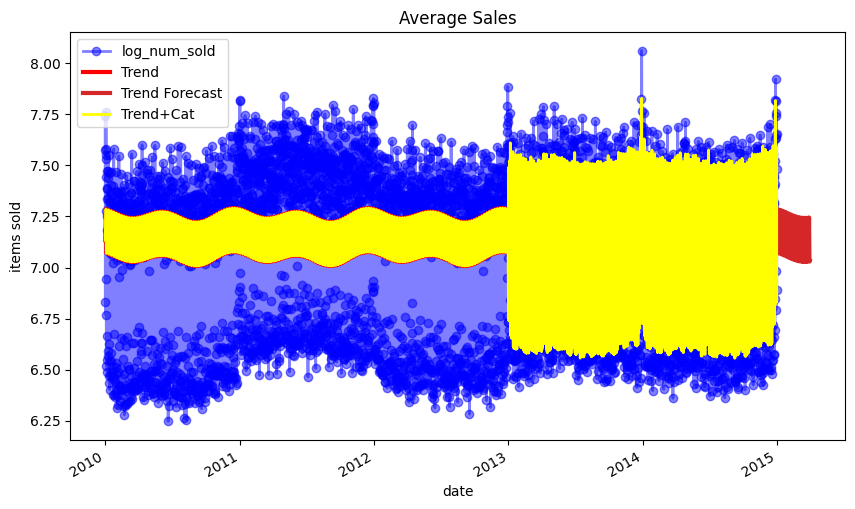

In [66]:
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import Fourier, Seasonality, TimeTrend
#Target series
#df=df_train[(df_train['country']=='Finland') & (df_train['store']=='Discount Stickers')]
#df=df_train[(df_train['country']=='Finland') & (df_train['store']=='Discount Stickers')].loc[:,['date','store','log_num_sold']].groupby(by=['date','store']).sum()
X2=df_train[(df_train['country']=='Finland') & (df_train['product']=='Kaggle')].drop(['id','country','num_sold','product'],axis=1).drop_duplicates()
df2=df_train[(df_train['country']=='Finland') & (df_train['product']=='Kaggle')].drop_duplicates().loc[:,['date','log_num_sold']].groupby(by=['date']).mean()
df=df_train[(df_train['country']=='Finland') & (df_train['product']=='Kaggle')].drop_duplicates().loc[:,['date','log_num_sold']]
df=df.reset_index(drop=True).set_index('date')

y_sum = df2.loc['2010':'2014','log_num_sold']
y = df.loc['2010':'2014', 'log_num_sold']
X2 = X2.set_index('date')
X2_train = X2.loc['2010':'2012',:].drop(['log_num_sold'],axis=1)
X2_test = X2.loc['2013':'2014',:].drop(['log_num_sold'],axis=1)
Y2_train = X2.loc['2010':'2012','log_num_sold']
Y2_test = X2.loc['2013':'2014','log_num_sold']


# X_1: Features for Linear Regression
tt = TimeTrend(constant=True)
four = Fourier(period=365.25, order=2)
seas = Seasonality(period=7)

dp = DeterministicProcess(
    index=y_sum.index,
    additional_terms=[tt,seas,four],
    )
X = dp.in_sample()
X_fore=dp.out_of_sample(steps=90,forecast_index= pd.date_range(start=X.index[-1]+pd.Timedelta(days=1), periods=90, freq="D"))

model = LinearRegression()
model.fit(X,y_sum)

y_pred = pd.Series(model.predict(X), index=X.index)
y_resid = y-y_pred
#y_resid = y_resid.stack().squeeze()

model2=cb.CatBoostRegressor(iterations=1000,learning_rate=0.03,depth=4)
model2.fit(
    X2_train.reset_index(drop=True),
    y_resid.loc['2010':'2012'].reset_index(drop=True),
    cat_features=cats,verbose=0)
y_pred_resid = pd.Series(model2.predict(X2_test.reset_index(drop=True)), index=X2_test.index)


y_t = y_pred.add(y_pred_resid,fill_value=0)

y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

plot_params = {"kind": "line","figsize": (10, 6),"color": "blue","linewidth": 2,"grid": True,"style": "-","marker": "o", "markersize": 6,"legend": False         
}

y_fore_resid2=pd.Series(model2.predict(X2.loc['2015':'2016',:].drop('log_num_sold',axis=1).reset_index(drop=True)),index=X2.loc['2015':'2016'].index)
t=y_fore.add(y_fore_resid2,fill_value=0).iloc[:min(len(y_fore),len(y_fore_resid2))]
t.index = pd.date_range(start=t.index[0], periods=len(t), freq='D')

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='red')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax = y_t.plot(ax=ax, linewidth=2, label="Trend+Cat", color='yellow')
ax.legend();



# X_2: Features for XGBoost
#X_2 = df.drop('sales', axis=1).stack()


#df['rolling_mean'] = df['num_sold'].rolling(window=30).mean()
#df['rolling_std'] = df['num_sold'].rolling(window=30).std()
#df[['num_sold', 'rolling_mean', 'rolling_std']].plot(ax=ax,title=f'Finland Rolling Mean and Std Dev')


In [ ]:
X2_train.columns

In [67]:
y_fore_resid2=pd.Series(model2.predict(X2.loc['2015':'2016',:].drop('log_num_sold',axis=1).reset_index(drop=True)),index=X2.loc['2015':'2016'].index)
t=y_fore.add(y_fore_resid2,fill_value=0).iloc[:min(len(y_fore),len(y_fore_resid2))]

In [62]:
t=y_fore.add(y_fore_resid2,fill_value=0).iloc[:min(len(y_fore),len(y_fore_resid2))]

In [68]:
t.index = pd.date_range(start=t.index[0], periods=len(t), freq='D')


In [61]:
cats

['store',
 'Day',
 'Month',
 'Year',
 'Day_of_week',
 'is_holiday',
 'Week_No',
 'is_weekend',
 'Quarter_Discrete',
 'store']

In [69]:
df.index

DatetimeIndex(['2010-01-01', '2010-01-01', '2010-01-01', '2010-01-02',
               '2010-01-02', '2010-01-02', '2010-01-03', '2010-01-03',
               '2010-01-03', '2010-01-04',
               ...
               '2016-12-28', '2016-12-29', '2016-12-29', '2016-12-29',
               '2016-12-30', '2016-12-30', '2016-12-30', '2016-12-31',
               '2016-12-31', '2016-12-31'],
              dtype='datetime64[ns]', name='date', length=7671, freq=None)

In [70]:
y_fore_resid = pd.Series(model2.predict(df_test.reset_index(drop=True)), index=df_test.index)

CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=0]=2017-01-01T00:00:00.000000000 : cat_features must be integer or string, real number values and NaN values should be converted to string.

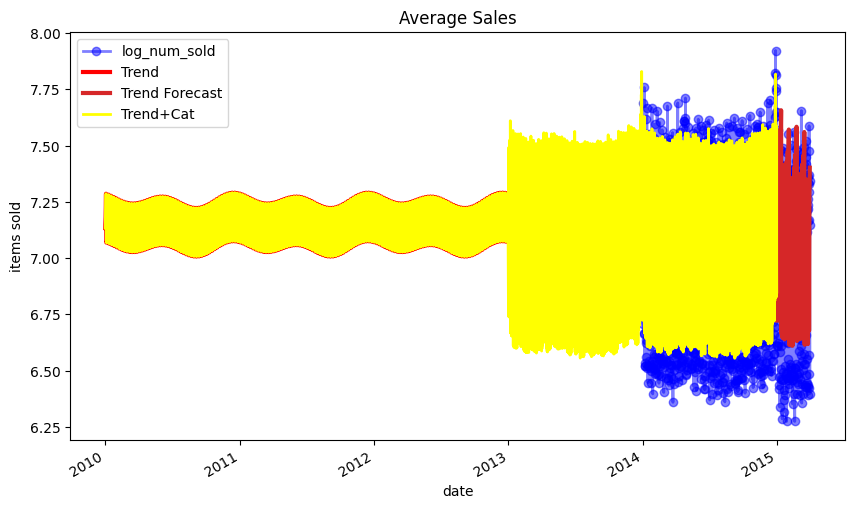

In [71]:
yx = df.loc['2014':'2015-03-31', 'log_num_sold']
ax = yx.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='red')
ax = t.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax = y_t.plot(ax=ax, linewidth=2, label="Trend+Cat", color='yellow')
ax.legend();


In [ ]:
from functools import partial
from catboost import cv

def objective(trial: optuna.Trial, country) -> float:
    #data, target = load_breast_cancer(return_X_y=True)
    #train_x, valid_x, train_y, valid_y = train_test_split(df_train.drop(['id','num_sold','date'],axis=1), df_train['num_sold'], test_size=0.25)
    #cats=df_train.select_dtypes('category').columns
    
    param = {
        "iterations":trial.suggest_int("iterations",1000,7000),
        "learning_rate":trial.suggest_float("learning_rate",0.006,0.03,log=True),
        "objective": trial.suggest_categorical("objective", ["MAPE"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.7, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
        "eval_metric": "MAPE",
        "cat_features": cats,
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

   
    #use catboost cv with timeseries data
    cv_data = cb.cv(
        cv_country_train_pool[c],
        params=param,
        shuffle=False,
        type='TimeSeries',
        fold_count=3,
        early_stopping_rounds=300,
        verbose=0,
    )
    mape = cv_data['test-MAPE-mean'].min()
    best_iter = cv_data['test-MAPE-mean'].values.argmin()
    # gbm = cb.CatBoostRegressor(**param)

    # pruning_callback = CatBoostPruningCallback(trial, "MAPE")
    # gbm.fit(
    #    # train_x,
    #    # train_y,
    #    # eval_set=[(valid_x, valid_y)],
    #     country_train_pool[c],
    #     eval_set=country_valid_pool[c],
    #     verbose=0,
    #     early_stopping_rounds=300,
    #     callbacks=[pruning_callback],
    # )

    # evoke pruning manually.
    #pruning_callback.check_pruned()

    
    #preds = gbm.predict(valid_x)
    #pred_labels = np.fix(preds)
    #mape = mean_absolute_percentage_error(valid_y, pred_labels)
    return mape


In [ ]:
from functools import partial 

country_best_params={}
for c in countrylist:
    objective = partial(objective, country = c)
    
    optuna.logging.set_verbosity(optuna.logging.CRITICAL)
    study = optuna.create_study(
        #pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), 
        direction="minimize",
    )
    study.optimize(objective, n_trials=100, timeout=600)
    
    print("Number of finished trials: {}".format(len(study.trials)))
    
    print(f'{c} Best trial:')
    trial = study.best_trial
    
    print("  Value: {}".format(trial.value))
    
    print(f"{c}  Params: ")
    country_best_params[c]=trial.params.copy()
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        

In [ ]:
#print(study.best_params)

In [ ]:
# from catboost import Pool,cv
# cats=df_train.select_dtypes('category').columns
# features=df_train.drop(['id','num_sold','date'],axis=1).columns
# train_pool = Pool(data=df_train.drop(['id','num_sold','date'],axis=1),
#              label=df_train['num_sold'],
#              cat_features=cats.to_list())

In [ ]:
# from catboost import Pool,cv

#              #feature_names=features)


# # params = {"iterations": 1000,
# #           "depth": 4,
# #           "loss_function": "MAPE",
# #           "verbose": False}

# scores = cv(train_pool,
#             study.best_params,
#            fold_count=5,
#             verbose=0,
#            )

# print(scores)

In [ ]:
#print(scores)

In [ ]:
#hyperdict=optuna.importance.get_param_importances(study)

In [ ]:
#print(hyperdict)

In [ ]:
for p,v in country_best_params.items():
    print(p)
    print(v)

In [ ]:
#Execute this cell in case of loading fitted model to do prediction
country_model={}
def LoadModel():
    Path='/kaggle/input/cbfitmodels'
    countrylist=['Canada','Finland','Italy','Kenya','Norway','Singapore']
    for c in countrylist:
        country_model[c]=cb.CatBoostRegressor().load_model(f'{Path}/cbfit_{c}')


In [ ]:
#Use when using model without training
LoadModel()

In [ ]:
country_best_params={}
country_best_params['Canada']={'iterations': 3593, 'learning_rate': 0.012827192029471704, 'objective': 'MAPE', 'colsample_bylevel': 0.09122674054287529, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3698567303900272}
country_best_params['Finland']={'iterations': 4674, 'learning_rate': 0.021005624891915504, 'objective': 'MAPE', 'colsample_bylevel': 0.5784183002099044, 'depth': 2, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.782146139508431}
country_best_params['Italy']={'iterations': 1398, 'learning_rate': 0.0251234589892742, 'objective': 'MAPE', 'colsample_bylevel': 0.049188944104342755, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}
country_best_params['Kenya']={'iterations': 3924, 'learning_rate': 0.016615674668667934, 'objective': 'MAPE', 'colsample_bylevel': 0.4274609331782009, 'depth': 2, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.2645325168308865}
country_best_params['Norway']={'iterations': 3851, 'learning_rate': 0.019929523358906295, 'objective': 'MAPE', 'colsample_bylevel': 0.07338903404462888, 'depth': 2, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}
country_best_params['Singapore']={'iterations': 1094, 'learning_rate': 0.02694754587058969, 'objective': 'MAPE', 'colsample_bylevel': 0.554849569101183, 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}

In [ ]:
#Train model with best param and iteration>1000 before prediction
country_model={}
for c in countrylist:
    country_model[c]=cb.CatBoostRegressor(**country_best_params[c],verbose=0)
    country_model[c].fit(country_train_pool[c],eval_set=country_valid_pool[c])
    country_model[c].save_model(f'cbfit_{c}')
    print(f'{c} {country_model[c].get_best_score()}')

In [ ]:
country_model

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
testcountrylist=df_test['country'].unique().tolist()
country_predicts={}
for i,c in enumerate(testcountrylist):
    df=df_test[df_test['country']==c]
    country_predicts[c] = np.expm1(country_model[c].predict(df.drop(['id','country'],axis=1)))
    df['num_sold']=country_predicts[c]
    df.set_index('date')
    df['rolling_mean'] = df['num_sold'].rolling(window=30).mean()
    df['rolling_std'] = df['num_sold'].rolling(window=30).std()
    df[['num_sold', 'rolling_mean', 'rolling_std']].plot(ax=axes.flat[i],title=f'{c} Rolling Mean and Std Dev')

plt.tight_layout()
plt.show()

In [ ]:
cdf={}
for c in testcountrylist:
    cid=df_test[df_test['country']==c]['id']
    cdf[c]=pd.concat([cid.reset_index(drop=True),pd.DataFrame(np.round(country_predicts[c],0),columns=['num_sold'])],axis=1)
   

In [ ]:
temp = pd.concat([df.reset_index(drop=True) for df in cdf.values()])

In [ ]:
temp=temp.drop_duplicates()

In [ ]:
temp.to_csv('submission_6country_dropna_spline_round.csv',index=False)

In [ ]:
cdf={}
for c in testcountrylist:
    cid=df_test[df_test['country']==c]['id']
    cdf[c]=pd.concat([cid.reset_index(drop=True),pd.DataFrame(np.fix(country_predicts[c]),columns=['num_sold'])],axis=1)

In [ ]:
#pd.concat([df_test['id'],pd.DataFrame(np.round(predicts,0),columns=['num_sold'])],axis=1).reset_index(drop=True).to_csv('submission_impute_dropna_holidays_conseddays.csv',index=False)
temp = pd.concat([df.reset_index(drop=True) for df in cdf.values()])
temp=temp.drop_duplicates()
temp.to_csv('submission_6country_dropna_spline_fix.csv',index=False)